<a href="https://colab.research.google.com/github/ealeongomez/Machine-Learning/blob/main/LR_Procces_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

from sklearn.preprocessing import StandardScaler

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

from scipy.stats import multivariate_normal


In [ ]:
def multivariate_gaussian(pos, mu, Sigma):
    """
      Calculo de la distribución Gaussian multivariada     
        Input: 

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

#**Gaussian procces Regressor**


- Un Gaussian Procces es un método probabilisitico que permite calcular un confianza una función pronósticada. su funcionamiento.

- Premiten realizar pronósticos sobre el conjunto de datos incorporando conocimientos previos

- Se usa en tareas de regresión lineal, clasificación y agrupamiento



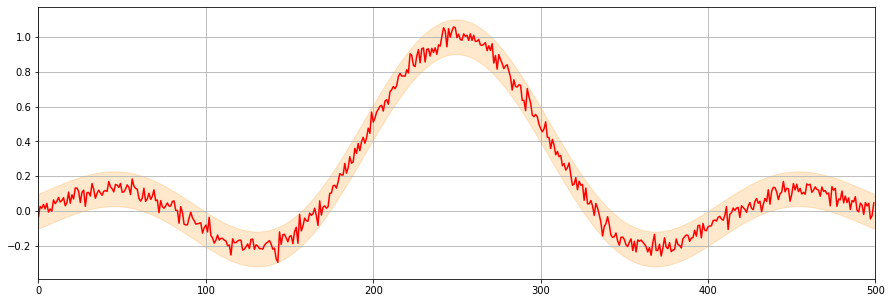

In [ ]:
N = 500
X = np.linspace(-3*np.pi,3*np.pi,N)
y = np.sinc(X/np.pi)

noise = np.sqrt(1e-3)*np.random.randn(X.shape[0])
yn = y + noise


plt.figure(figsize=(15, 5))
plt.plot(yn, c='r', label='Time serie')
plt.xlim(0,len(y))
plt.fill_between(np.arange(0,len(y),1), np.squeeze(y)-0.1, np.squeeze(y)+0.1, color='darkorange', alpha=0.2, label='Shared')
plt.grid()
plt.show()


Distribuciones gaussianas multivariadas


- Cada variable aleatoria se distribuye normalmente y su distribución conjunta también es gaussiana.

$$ X = \begin{bmatrix} x_1 \\ {x_2}\\ \vdots\\{x_n}\end{bmatrix} \sim \eta ( \mu ,\Sigma) $$

Donde$\mu$ es el calor esperado de la distribución 

Decimos que los datos $X$ siguen una distribución de normal, si la matriz de covarianza $\Sigma$ describe la forma de distribución, la cual esta definida como:

$$\Sigma = Cov(X_I, X_j) = E \left[(X_I -\mu_I)(X_j -\mu_j)^\top \right]$$


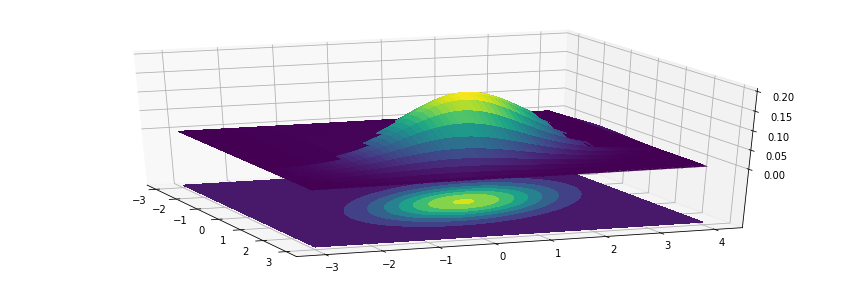

In [ ]:
N = 60
A = np.linspace(-3, 3, N)
A = np.linspace(-3, 4, N)
A, B = np.meshgrid(X_, Y_)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(A.shape + (2,))
pos[:, :, 0] = A
pos[:, :, 1] = B

mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

# The distribution on the variables X, Y packed into pos.
C = multivariate_gaussian(pos, mu, Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(15, 5))
ax = fig.gca(projection='3d')
ax.plot_surface(A, B, C, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

cset = ax.contourf(A, B, C, zdir='z', offset=-0.15, cmap=cm.viridis)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.2)
ax.set_zticks(np.linspace(0,0.2,5))
ax.view_init(27, -21)

plt.show()


Kernel RBF de Gaussian Process

$$k(x_i, x_j) = C * exp \left( -\frac{d(x_i,x_j)}{2l^2} \right) $$

Donde $d(x_i,x_j)$ es la disancia euclidea y $l$ es la escala del kernel

#**Machine Learning**

In [ ]:
Xdata = X.reshape(-1,1)

var_list = [1e-4, 1e-3, 1e-2, 1e-1]
mue = 0

# Parametros del kernel 
l = 0.1
sigma_f = 2
sigma_n = 0.4

# kernel 
kernels = [
           ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=1, length_scale_bounds=(1e-2, 1e2)), 
           ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=10, length_scale_bounds=(1e-2, 1e2)),
           ConstantKernel(constant_value=sigma_f, constant_value_bounds=(1e-2, 1e2)) \
            * RBF(length_scale=100, length_scale_bounds=(1e-2, 1e2))]
                   
param_grid = {'alpha':[1e-3, 1e-2, 1e-1, 1, 10], 
              'kernel':kernels}

plt.figure(figsize=(35, 5))
for i in range(len(var_list)):
  var = var_list[i]

  noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])
  yn = y + noise

  # Selección del conjunto
  ydata = yn.reshape(-1,1)
  
  # Fragmentación de los datos
  X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.3)

  # Validación 
  grid_search = GridSearchCV(estimator=GaussianProcessRegressor(),
                             param_grid=param_grid,
                             cv=10,
                             verbose=0,
                             n_jobs=-1, 
                             scoring='neg_mean_absolute_error')

  grid_search.fit(X_train, y_train)

  # Mejor modelo entrenado
  best_model = grid_search.best_estimator_

  print("\nMejores parámetros para el modelo con ruido {}\n".format(i+1))
  print(grid_search.best_params_)

  y_pred, y_std = grid_search.best_estimator_.predict(X_test, return_std=True)

  plt.subplot(1, len(var_list), int(i)+1)
  plt.plot(X, y, 'r', label='Target')
  plt.plot(X, yn, 'k.', label='data')
  plt.plot(X_train, y_train,'c.',label='train' )
  plt.plot(X_test, y_test,'b.',label='test')
  plt.plot(X_test, y_pred, 'g.', label='Forecasting')
  
  #plt.fill_between(np.squeeze(X_test), np.squeeze(y_pred), np.squeeze(y_pred)-y_std, np.squeeze(y_pred)+y_std, color='darkorange', alpha=0.2)
  
  plt.title("Data set {}".format(i+1))
  plt.grid()
  plt.legend()
